# 0. Preparación del entorno

In [133]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from statsmodels.tsa.stattools import acf

In [1]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [135]:
os.environ['RUTA_SIMULACIONES'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/simulaciones/'
os.environ['RUTA_DATASETS'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/datasets/'
os.environ['DATASET_CONSUMOS'] = 'consumos_casas_1-99'
os.environ['MAX_HOUSE_LOAD'] = '99'

# 1. Arquitectura

## 1.1. Utils

### 1.1.1. Carga y procesamiento de datos de consumo

In [4]:
def obtener_ruta_archivo(nombre: str, parte: int = 0):
  ruta_archivo = f"{os.environ.get('RUTA_SIMULACIONES')}{nombre}"
  if parte != 0:
    ruta_archivo += f"_part{parte}"
  ruta_archivo += ".xlsx"
  return ruta_archivo

assert obtener_ruta_archivo("House1", 1) == os.environ.get('RUTA_SIMULACIONES') + 'House1_part1.xlsx'
assert obtener_ruta_archivo("House1", 0) == os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx'

In [5]:
def obtener_n_dias(ruta_archivo: str):
  xls = pd.ExcelFile(ruta_archivo)
  return len([d for d in xls.sheet_names if d.startswith('Day')]);

assert obtener_n_dias(os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx') == 10

In [6]:
def leer_consumo_excel(dia: int, casa: str, parte: int = 0):
  serie = pd.read_excel(obtener_ruta_archivo(casa, parte), sheet_name=f'Day{dia}', header=None).iloc[0]
  data = [int(x) for x in serie if not isinstance(x, str)]
  return data

### 1.1.2. Localización de eventos discontinuos

In [136]:
def calcular_autocorrelacion(serie: list[int], nlags: int, lags_offset: int = 3):
  autocorrelacion, intervalo_confianza = acf(serie, nlags=nlags, alpha=0.05)
  autocorrelacion = autocorrelacion[lags_offset:]
  intervalo_confianza = intervalo_confianza[lags_offset:]

  return (autocorrelacion, intervalo_confianza)

In [137]:
def calcular_umbral_lower(intervalo_confianza: np.array):
  lowers = []
  for lower, upper in intervalo_confianza:
    lowers.append(lower)

  media_lowers = np.mean(lowers)
  umbral_lower = media_lowers + np.std(lowers)
  return umbral_lower

In [144]:
def localizar_repeticiones(serie: list[int], min_inicio: int, umbral_separacion_ecd: int, lags_offset: int = 3):
  autocorrelacion, intervalo_confianza = calcular_autocorrelacion(serie, len(serie) - 1)
  umbral_lower = calcular_umbral_lower(intervalo_confianza)

  repeticiones = []
  distancia_ultima_repeticion = lags_offset - 1
  for lag, val, (lower, upper) in zip(range(lags_offset, len(autocorrelacion) + lags_offset), autocorrelacion, intervalo_confianza):
    distancia_ultima_repeticion += 1
    if lower > umbral_lower and distancia_ultima_repeticion > umbral_separacion_ecd:
      repeticiones.append((lag + min_inicio, distancia_ultima_repeticion))
      distancia_ultima_repeticion = 0

  return repeticiones


## 1.2. Modelos

In [7]:
class Consumo:
  def __init__(self, dia: int, casa: str, parte: int = 0, serie: list[int] = []):
    self.dia: int = dia
    self.casa: str = casa
    self.parte: int = parte
    self._serie: list[int] = serie

  def get_serie(self) -> list[int]:
    return [c for c in self._serie]

  def leer_serie(self):
    self._serie = leer_consumo_excel(self.dia, self.casa, self.parte)

In [8]:
class GrupoConsumos:
  def __init__(self):
    self._consumos: list[Consumo] = []
    self._n_consumos = 0

  def get_consumos(self) -> list[Consumo]:
    return [c for c in self._consumos]

  def get_consumo(self, dia: int, casa: str, parte: int = 0) -> Consumo:
    return next((c for c in self._consumos if c.dia == dia and c.casa == casa and c.parte == parte), None)

  def add_consumo(self, consumo: Consumo):
    self._consumos.append(consumo)
    self._n_consumos += 1

  def guardar_como_excel(self, nombre_archivo: str = 'consumos_casas_1-100'):
    data = []
    for consumo in self._consumos:
      data.append({
        'dia': consumo.dia,
        'casa': consumo.casa,
        'parte': consumo.parte,
        'serie': consumo.get_serie()
      })
    df = pd.DataFrame(data)
    df.to_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx", index=False)

  def carga_desde_excel(self, nombre_archivo: str):
    df = pd.read_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx")
    self._consumos = []
    self._n_consumos = 0
    for _, row in df.iterrows():
      consumo = Consumo(row['dia'], row['casa'], row['parte'], eval(row['serie']))
      self.add_consumo(consumo)


In [ ]:
class Evento():
  def __init__(self, id, serie: list[int], min_inicio: int, consumo_origen: Consumo):
    self.id = id
    self._serie = serie
    self.min_inicio = min_inicio
    self._consumo_origen = consumo_origen

# X. Main

### Generación o lectura del dataset con todas las series temporales de consumo

In [9]:
consumos_simulados = GrupoConsumos()
dataset_consumos = os.environ.get('DATASET_CONSUMOS')

if dataset_consumos == '':
  for i in range(1, int(os.environ.get('MAX_HOUSE_LOAD')) + 1):
    casa = f"House{i}"
    for d in range(1, obtener_n_dias(obtener_ruta_archivo(casa)) + 1):
      consumo = Consumo(d, casa)
      consumo.leer_serie()
      consumos_simulados.add_consumo(consumo)
  consumos_simulados.guardar_como_excel(f"consumos_casas_1-{os.environ.get('MAX_HOUSE_LOAD')}")
else:
  consumos_simulados.carga_desde_excel(dataset_consumos)

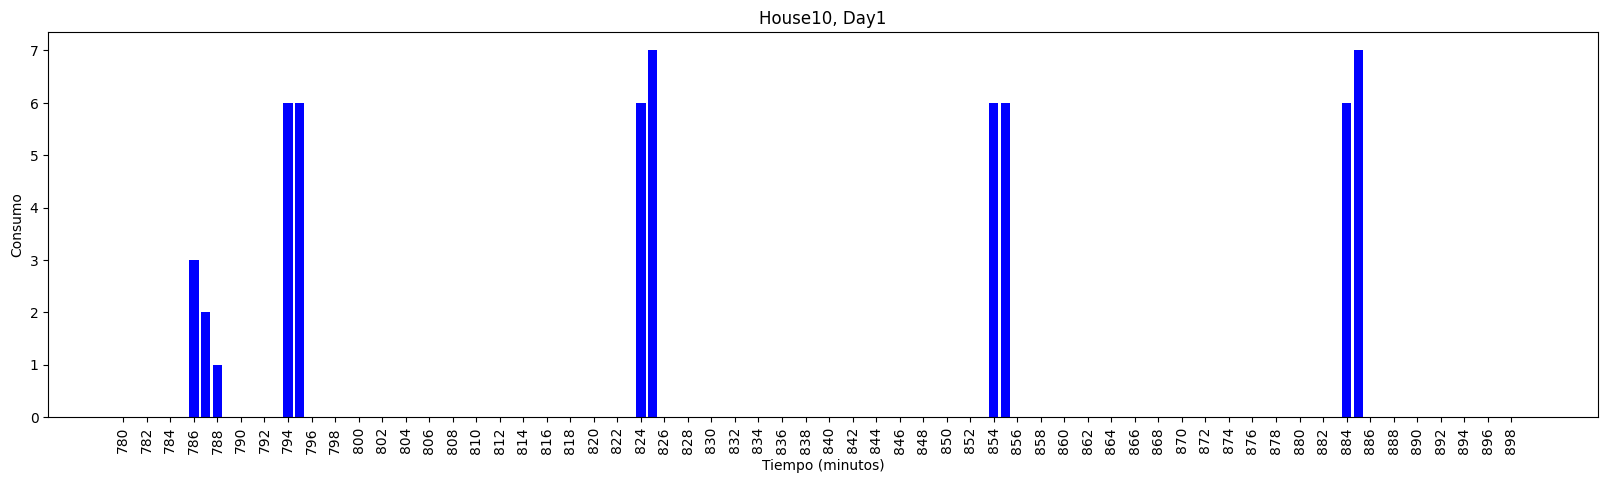

In [151]:
consumo_ejemplo = next(consumo for consumo in consumos_simulados.get_consumos() if max(consumo.get_serie()) > 7 and sum(consumo.get_serie()) > 150)
consumo_ejemplo = consumos_simulados.get_consumo(1, "House10")

inicio = 780
fin = 900
intervalo = 2
serie_ejemplo = consumo_ejemplo.get_serie()[inicio:fin]

plt.figure(figsize=(20, 5))
plt.bar(range(inicio, fin), serie_ejemplo, color='blue')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Consumo')
plt.title(f'{consumo_ejemplo.casa}, Day{consumo_ejemplo.dia}')
plt.xticks(range(inicio, fin, intervalo), rotation=90)
plt.show()


In [152]:
localizar_repeticiones(serie_ejemplo, 0, 10)

[(29, 29), (59, 30), (90, 31)]

In [ ]:
from statsmodels.tsa.stattools import acf

autocorr, conf_int = acf(serie_ejemplo, nlags=100, alpha=0.05)
autocorr = autocorr[4:]
conf_int = conf_int[4:]

num_repeticiones = 0
distancia_ultima_repeticion = 0
for lag, val, (lower, upper) in zip(4, range(len(autocorr) + 4), autocorr, conf_int):
    if val < lower or val > upper:
        num_significativos += 1

# Imprimir los resultados
if num_significativos > 3:
    print(f"Se detectaron más de 3 repeticiones significativas ({num_significativos} repeticiones) en los primeros 100 lags.")
else:
    print(f"No se detectaron más de 3 repeticiones significativas en los primeros 100 lags ({num_significativos} repeticiones).")

# Visualizar la función de autocorrelación con intervalos de confianza
plt.figure(figsize=(10, 4))
plt.stem(range(len(autocorr)), autocorr, use_line_collection=True)
plt.fill_between(range(len(autocorr)), conf_int[:, 0], conf_int[:, 1], color='r', alpha=0.1)
plt.title('Función de Autocorrelación del Consumo de Agua')
plt.xlabel('Retraso (Lags)')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()

# Imprimir la autocorrelación y los intervalos de confianza
print("Autocorrelación e Intervalos de Confianza:")
for lag, val, (lower, upper) in zip(range(len(autocorr)), autocorr, conf_int):
    print(f"Lag {lag}: {val:.3f}, Intervalo de Confianza: ({lower:.3f}, {upper:.3f})")


Una serie temporal para cada grupo de eventos según su consumo:
- De alto consumo
- De bajo consumo

# Code testing

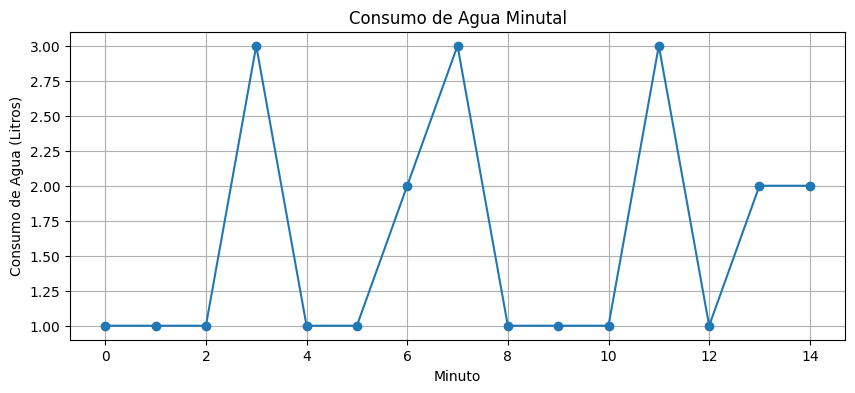

<Figure size 1000x400 with 0 Axes>

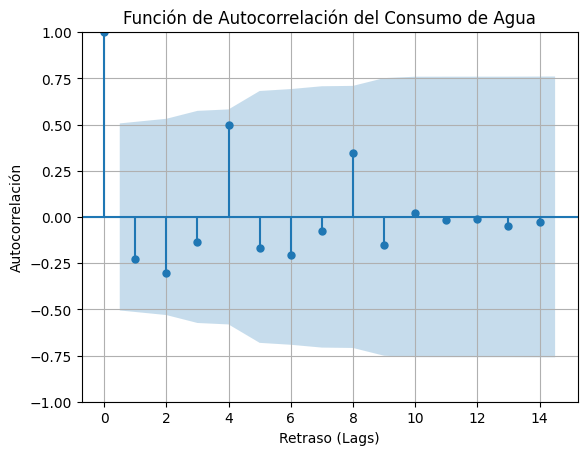

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

serie_ejemplo = [1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 1, 3, 1, 2, 2]
inicio = 0
fin = len(serie_ejemplo)

plt.figure(figsize=(10, 4))
plt.plot(serie_ejemplo, marker='o')
plt.title('Consumo de Agua Minutal')
plt.xlabel('Minuto')
plt.ylabel('Consumo de Agua (Litros)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(serie_ejemplo, lags=(fin - inicio - 1))
plt.title('Función de Autocorrelación del Consumo de Agua')
plt.xlabel('Retraso (Lags)')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()



In [150]:
localizar_repeticiones(serie_ejemplo, 0, 10)


[(29, 29), (59, 30), (90, 31)]

In [118]:
from statsmodels.tsa.stattools import acf
autocorr, conf_int = acf(serie_ejemplo, nlags=(fin - inicio - 1), alpha=0.05)
lowers = []
for lower, upper in conf_int[3:]:
  lowers.append(lower)
media_lowers = np.mean(lowers)
umbral_significativo = media_lowers + np.std(lowers)  # Umbral basado en la media y desviación estándar
print(umbral_significativo)

-0.4762921770150438


In [119]:
print("Autocorrelación e Intervalos de Confianza:")
for lag, val, (lower, upper) in zip(range(len(autocorr)), autocorr, conf_int):
    print(f"Lag {lag}: {val:.3f}, Intervalo de Confianza: ({lower:.3f}, {upper:.3f})")

Autocorrelación e Intervalos de Confianza:
Lag 0: 1.000, Intervalo de Confianza: (1.000, 1.000)
Lag 1: -0.225, Intervalo de Confianza: (-0.731, 0.281)
Lag 2: -0.304, Intervalo de Confianza: (-0.835, 0.227)
Lag 3: -0.133, Intervalo de Confianza: (-0.707, 0.441)
Lag 4: 0.496, Intervalo de Confianza: (-0.086, 1.078)
Lag 5: -0.167, Intervalo de Confianza: (-0.848, 0.515)
Lag 6: -0.204, Intervalo de Confianza: (-0.896, 0.488)
Lag 7: -0.075, Intervalo de Confianza: (-0.782, 0.632)
Lag 8: 0.346, Intervalo de Confianza: (-0.363, 1.055)
Lag 9: -0.150, Intervalo de Confianza: (-0.901, 0.601)
Lag 10: 0.021, Intervalo de Confianza: (-0.738, 0.780)
Lag 11: -0.017, Intervalo de Confianza: (-0.776, 0.742)
Lag 12: -0.012, Intervalo de Confianza: (-0.771, 0.746)
Lag 13: -0.050, Intervalo de Confianza: (-0.809, 0.709)
Lag 14: -0.025, Intervalo de Confianza: (-0.785, 0.735)


In [74]:
# Decisión sobre la repetición basada en la autocorrelación
def hay_repeticion(autocorr, umbral=0.2):
    for lag, val in enumerate(autocorr):
        if lag != 0 and abs(val) > umbral:
            return True, lag
    return False, None

umbral_autocorrelacion = 0.2
repeticion, lag = hay_repeticion(autocorr, umbral_autocorrelacion)

if repeticion:
    print(f"Se detectó una repetición significativa en el lag {lag}.")
else:
    print("No se detectaron repeticiones significativas.")


Se detectó una repetición significativa en el lag 1.


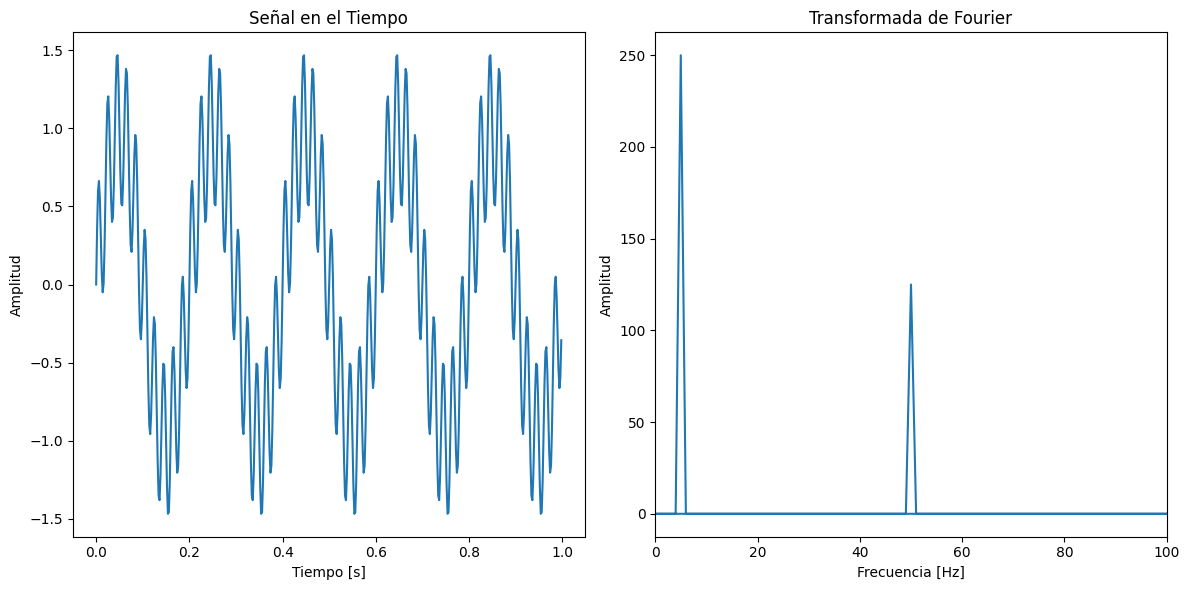

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Crear una señal de ejemplo (suma de dos sinusoides)
fs = 500  # Frecuencia de muestreo
t = np.arange(0, 1, 1/fs)  # Vector de tiempo
f1, f2 = 5, 50  # Frecuencias de las sinusoides
signal = np.sin(2*np.pi*f1*t) + 0.5*np.sin(2*np.pi*f2*t)  # Señal

# Aplicar la Transformada de Fourier
fft_signal = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(fft_signal), 1/fs)

# Visualización de la señal original y su transformada
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t, signal)
plt.title('Señal en el Tiempo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

plt.subplot(1, 2, 2)
plt.plot(frequencies, np.abs(fft_signal))
plt.title('Transformada de Fourier')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.xlim(0, 100)  # Limitar a las frecuencias de interés

plt.tight_layout()
plt.show()


# Series Reales

In [34]:
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 4, 2, 1, 4, 2, 6, 2, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 6, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 4, 5, 3, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 3, 1, 0, 0, 0, 0, 0, 0, 5, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 6, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [53]:
serie_real[1382:1398]

[0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]

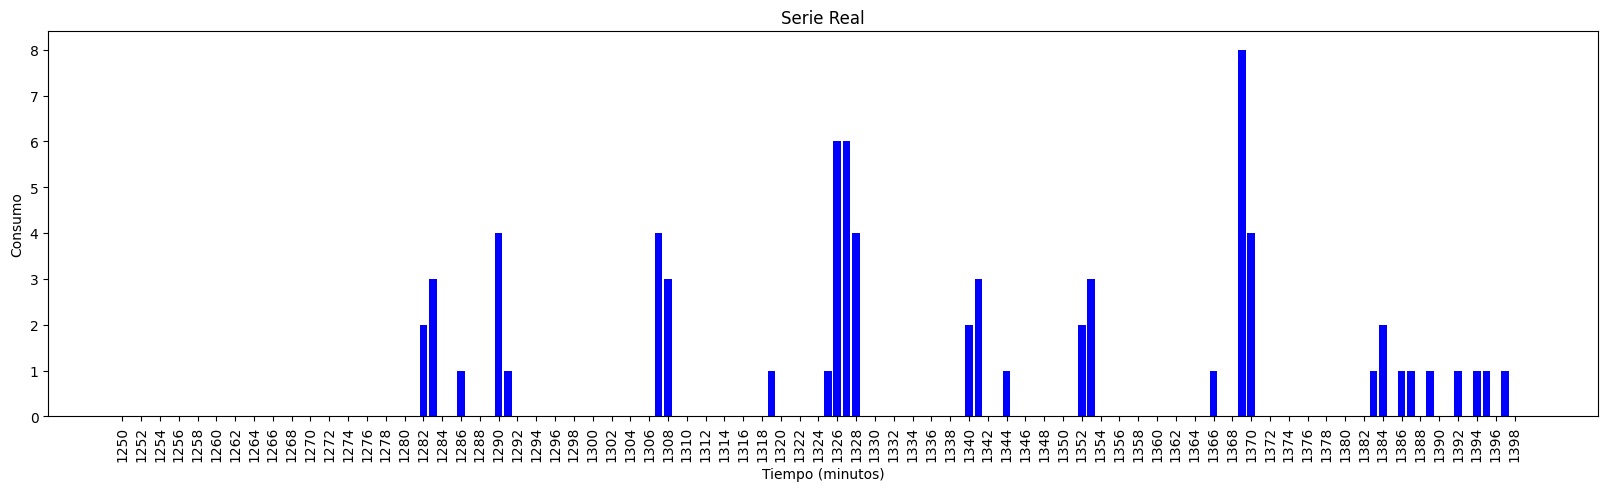

In [146]:
inicio = 1250
fin = 1400
plt.figure(figsize=(20, 5))  # Tamaño de la figura
plt.bar(range(inicio, fin), serie_real[inicio:fin], color='blue')
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Consumo')
plt.title(f'Serie Real')
plt.xticks(range(inicio, fin, 2), rotation=90)
plt.show()

In [149]:
localizar_repeticiones(serie_real[1282:fin], 0, 10)

[(14, 14), (25, 11), (41, 16), (61, 20), (79, 18)]

In [33]:
# serie_consumo = []
# ultimo_min_fin = 0
# for e in serie_eventos:
#   serie_consumo += [0]*(e["start"] - ultimo_min_fin) + e["serie"]
#   ultimo_min_fin = e["end"] + 1
# serie_consumo += [0]* (1440 - ultimo_min_fin)
# print(serie_consumo)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 